In [2]:
import gymnasium as gym
import stable_baselines3
import argparse
import crafter
from shimmy import GymV21CompatibilityV0
from gymnasium.envs.registration import register

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
import os
import gym
import crafter
from shimmy import GymV21CompatibilityV0

# -----------------------------
# Create Gymnasium-compatible environment
# -----------------------------
raw_env = crafter.Env()
env_v0 = GymV21CompatibilityV0(env=raw_env)
env = GymV21CompatibilityV0(env=raw_env)  # wrap for Gymnasium

# Test
obs, info = env.reset()
print("Observation shape:", obs.shape)
print("Action space:", env.action_space)


Observation shape: (64, 64, 3)
Action space: Discrete(17)


In [4]:
import torch
print(torch.cuda.is_available())  # Should print True if GPU is detected
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))


True
0
NVIDIA GeForce RTX 4050 Laptop GPU


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def plot_tensorboard_run(run_dir, save_dir=None):
    """
    Generate smooth plots for all common metrics in a single TensorBoard run.

    Parameters:
        run_dir (str): Path to a TensorBoard event log folder (e.g. ./logdir/crafter_reward-dqn/base/DQN_3)
        save_dir (str, optional): If provided, saves PNGs of each metric plot
    """
    if not os.path.exists(run_dir):
        raise FileNotFoundError(f"Run folder not found: {run_dir}")

    print(f"Loading TensorBoard data from: {run_dir}")

    # Load TensorBoard scalars
    ea = event_accumulator.EventAccumulator(run_dir)
    ea.Reload()
    tags = ea.Tags().get("scalars", [])
    if not tags:
        print("No scalar data found in this run.")
        return

    print(f"Found {len(tags)} scalar metrics")

    # Make output dir if needed
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # Smooth helper
    def smooth(values, window=50):
        if len(values) < window:
            return values
        return np.convolve(values, np.ones(window) / window, mode="valid")

    # Plot each scalar
    for tag in tags:
        events = ea.Scalars(tag)
        steps = np.array([e.step for e in events])
        values = np.array([e.value for e in events])

        if len(values) == 0:
            continue

        smoothed = smooth(values)

        plt.figure(figsize=(8, 4))
        plt.plot(steps[:len(smoothed)], smoothed, label=tag, linewidth=2, color="tab:blue")
        plt.title(f"{tag} vs Time Steps")
        plt.xlabel("Time Steps")
        plt.ylabel(tag)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()

        if save_dir:
            file_name = tag.replace("/", "_") + ".png"
            plt.savefig(os.path.join(save_dir, file_name))
            print(f" Saved: {file_name}")

        plt.show()

    print("All available scalar metrics plotted successfully.")


In [ ]:

import os
import torch
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage
from stable_baselines3.common.monitor import Monitor
import crafter
from shimmy import GymV21CompatibilityV0

# ------------- config -------------
OUTDIR = "./logdir/crafter_reward-dqn/base"
TOTAL_TIMESTEPS = 100_000
os.makedirs(OUTDIR, exist_ok=True)

# Detect device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# -----------------------------------

# Create environment (wrap with Monitor to allow SB3 to log episode rewards)
raw_env = crafter.Env()
env_v0 = GymV21CompatibilityV0(env=raw_env)

def make_env():
    e = env_v0
    e = Monitor(e, filename=None) 
    return e

env = DummyVecEnv([lambda: make_env()])
env = VecTransposeImage(env)  

# -----------------------------
# Create DQN model (use GPU if available)
# -----------------------------
model = DQN(
    "CnnPolicy",        
    env,               
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    gamma=0.99,
    train_freq=4,
    target_update_interval=1000,
    verbose=1,
    device=device,     
    tensorboard_log=OUTDIR
)
# -----------------------------
# Train
# -----------------------------
model.learn(total_timesteps=TOTAL_TIMESTEPS)
model.save(os.path.join(OUTDIR, "dqn_crafter"))

env.close()
print("Training complete. Model saved to:", os.path.join(OUTDIR, "dqn_crafter"))
print("Start tensorboard with: tensorboard --logdir=" + os.path.join(OUTDIR, "tb_logs"))


Using device: cuda
Using cuda device
Logging to ./logdir/crafter_reward-dqn/base\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 136      |
|    time_elapsed     | 3        |
|    total_timesteps  | 544      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 115      |
|    time_elapsed     | 10       |
|    total_timesteps  | 1231     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00164  |
|    n_updates        | 57       |
----------------------------------
---

Loading TensorBoard data from: ./logdir/crafter_reward-dqn/base/DQN_1
Found 6 scalar metrics
 Saved: rollout_ep_len_mean.png


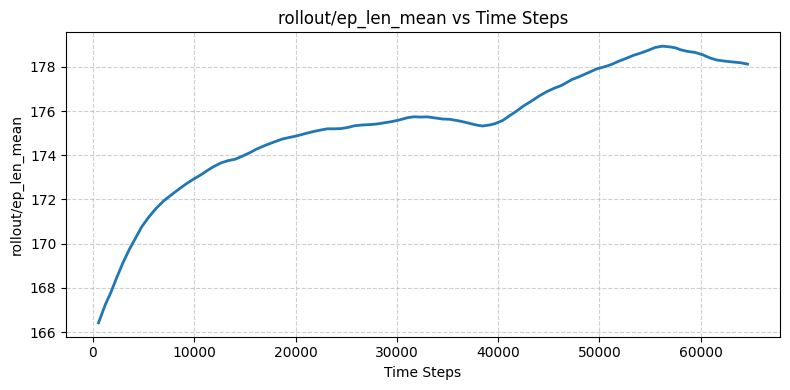

 Saved: rollout_ep_rew_mean.png


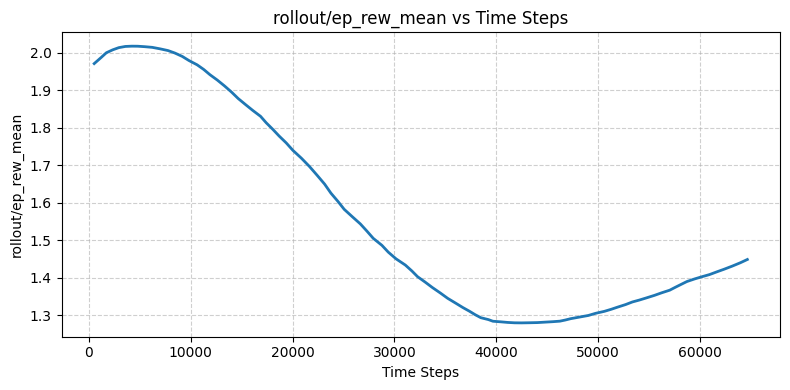

 Saved: rollout_exploration_rate.png


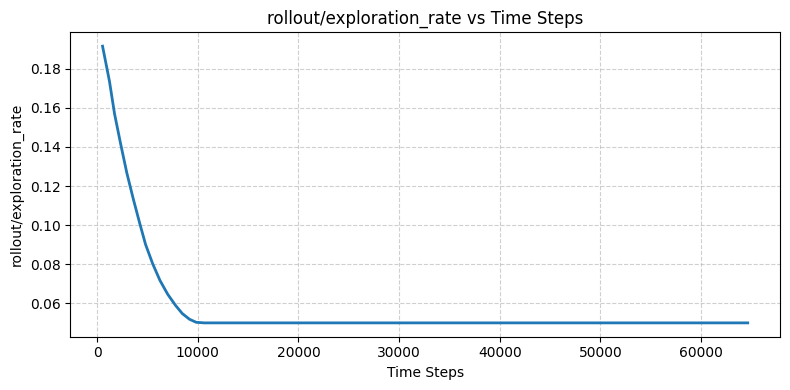

 Saved: time_fps.png


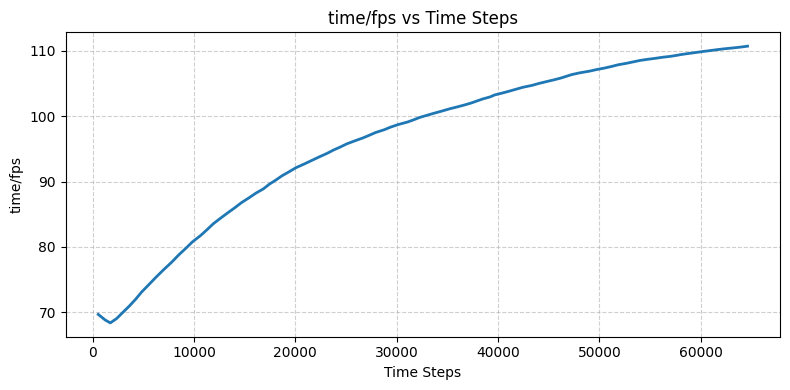

 Saved: train_learning_rate.png


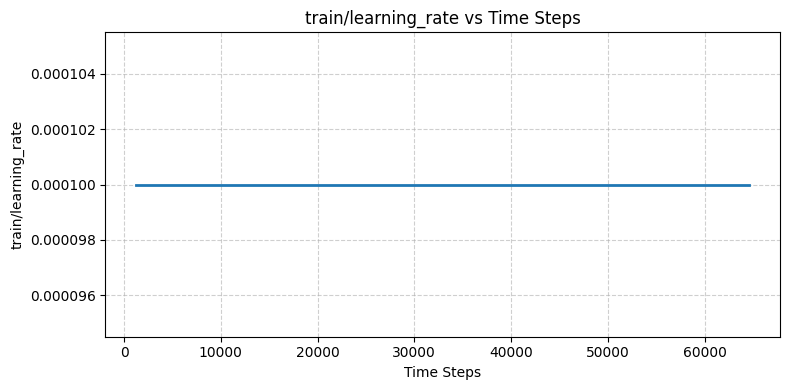

 Saved: train_loss.png


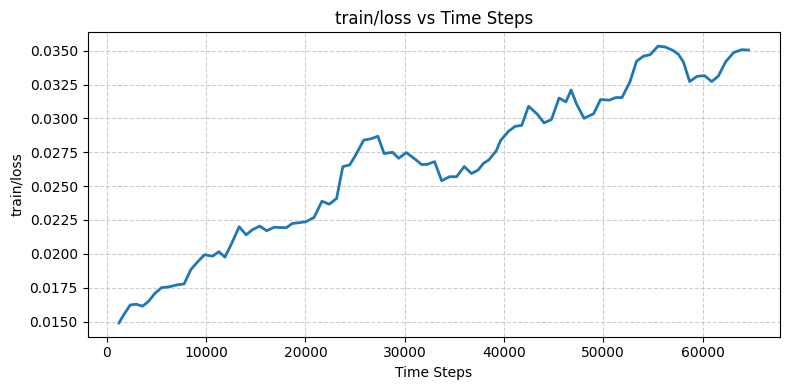

✅All available scalar metrics plotted successfully.


In [ ]:

plot_tensorboard_run(
    run_dir="./logdir/crafter_reward-dqn/base/DQN_1",
    save_dir="./logdir/crafter_reward-dqn/plots"
)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
import crafter
from shimmy import GymV21CompatibilityV0
import numpy as np

# ---------------------- CONFIG ----------------------
OUTDIR = "./logdir/crafter_reward-dqn/auto_encoder"
TOTAL_TIMESTEPS = 100_000
os.makedirs(OUTDIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ---------------------- ENV SETUP ----------------------
raw_env = crafter.Env()
env_v0 = GymV21CompatibilityV0(env=raw_env)

def make_env():
    e = env_v0
    e = Monitor(e, filename=None)
    return e

base_env = make_env()

# ---------------------- AUTOENCODER ----------------------
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

# ---------------------- AUTOENCODER PRETRAINING ----------------------
autoencoder = AutoEncoder(latent_dim=128).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

writer = SummaryWriter(log_dir=os.path.join(OUTDIR, "autoencoder"))

print("Collecting frames for autoencoder pretraining...")
frames = []
obs, _ = base_env.reset()
for _ in range(2000):  
    action = base_env.action_space.sample()
    obs, _, done, _, _ = base_env.step(action)
    frames.append(obs)
    if done:
        obs, _ = base_env.reset()

frames = np.array(frames) / 255.0
frames = torch.tensor(frames.transpose(0, 3, 1, 2), dtype=torch.float32).to(device)

print("Training autoencoder on collected frames...")
for epoch in range(10):
    optimizer.zero_grad()
    recon, _ = autoencoder(frames)
    loss = criterion(recon, frames)
    loss.backward()
    optimizer.step()
    writer.add_scalar("Autoencoder/Loss", loss.item(), epoch)
    print(f"Epoch {epoch+1}/10 | Loss: {loss.item():.6f}")

writer.close()
torch.save(autoencoder.state_dict(), os.path.join(OUTDIR, "autoencoder.pth"))
print("Autoencoder pretrained and saved.")


env = DummyVecEnv([make_env])  

model = DQN(
    "CnnPolicy", 
    env,
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    target_update_interval=1000,
    verbose=1,
    device=device,
    tensorboard_log=OUTDIR,
)

model.learn(total_timesteps=TOTAL_TIMESTEPS, tb_log_name="DQN_Crafter_Auto_Encoder")
model.save(os.path.join(OUTDIR, "dqn_crafter_auto_encoder"))
env.close()

print("Training complete. Model saved.")


Using device: cuda
Training autoencoder on collected frames...
Epoch 1/10 | Loss: 0.147020
Epoch 2/10 | Loss: 0.146417
Epoch 3/10 | Loss: 0.145666
Epoch 4/10 | Loss: 0.144320
Epoch 5/10 | Loss: 0.141135
Epoch 6/10 | Loss: 0.133553
Epoch 7/10 | Loss: 0.119510
Epoch 8/10 | Loss: 0.111813
Epoch 9/10 | Loss: 0.111559
Epoch 10/10 | Loss: 0.100628
Autoencoder pretrained and saved.
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./logdir/crafter_reward-dqn/auto_encoder\DQN_Crafter_Auto_Encoder_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 50       |
|    time_elapsed     | 13       |
|    total_timesteps  | 668      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170  

Loading TensorBoard data from: ./logdir/crafter_reward-dqn/auto_encoder\DQN_Crafter_Auto_Encoder_1
Found 6 scalar metrics
 Saved: rollout_ep_len_mean.png


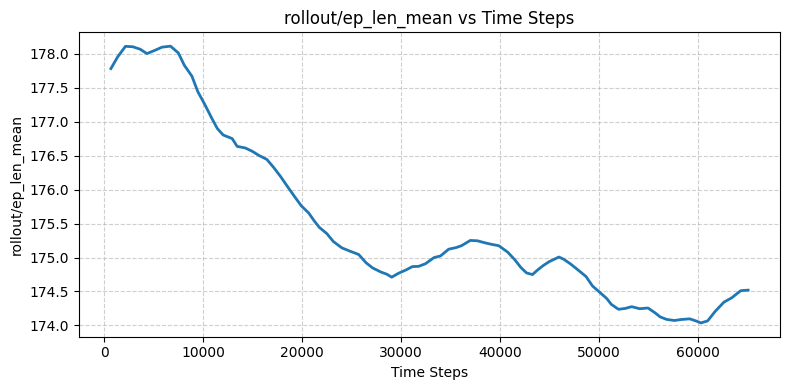

 Saved: rollout_ep_rew_mean.png


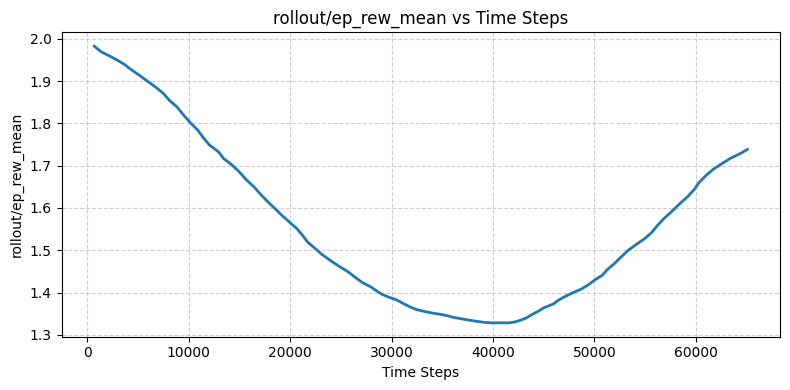

 Saved: rollout_exploration_rate.png


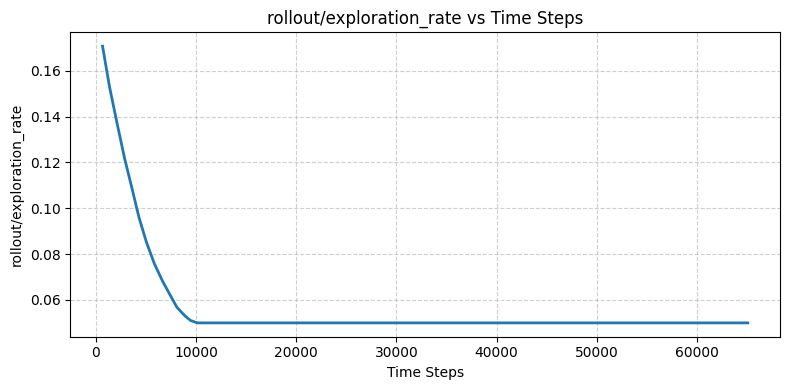

 Saved: time_fps.png


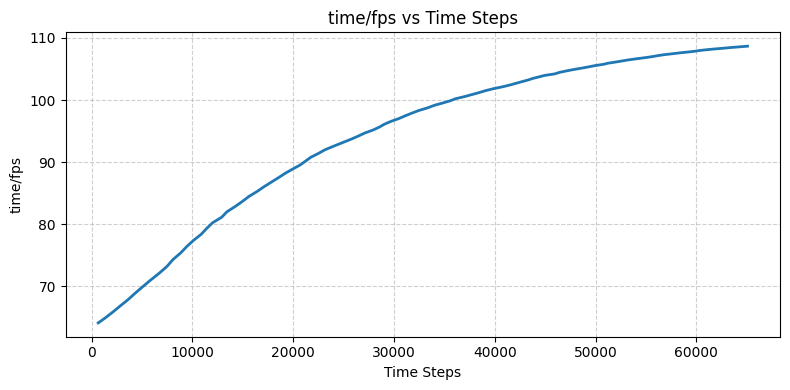

 Saved: train_learning_rate.png


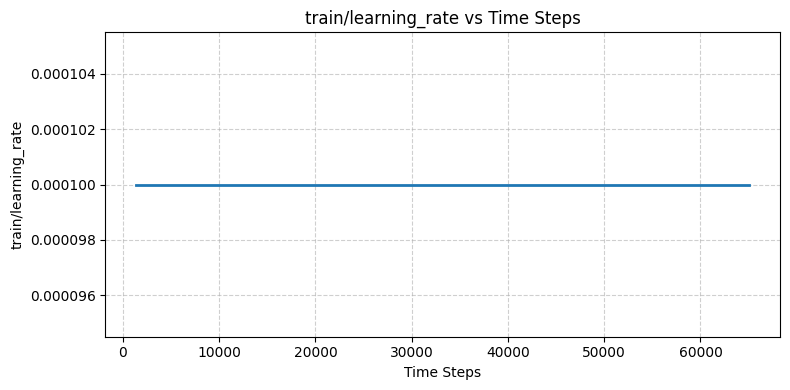

 Saved: train_loss.png


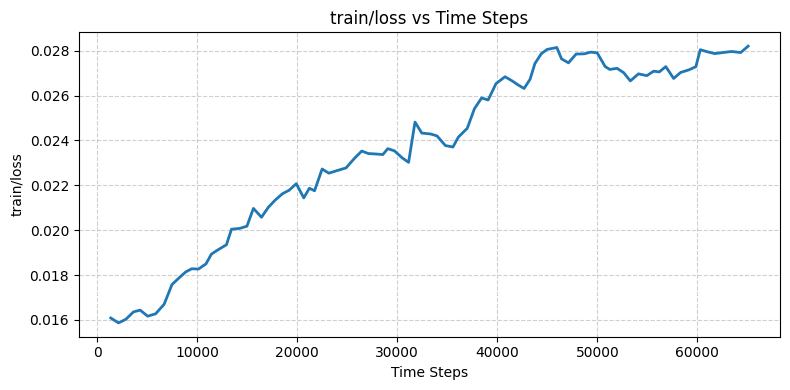

✅All available scalar metrics plotted successfully.


In [15]:
plot_tensorboard_run(
    run_dir="./logdir/crafter_reward-dqn/auto_encoder\DQN_Crafter_Auto_Encoder_1",
    save_dir="./logdir/crafter_reward-dqn/plots"
)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.monitor import Monitor
import crafter
from shimmy import GymV21CompatibilityV0
import numpy as np

OUTDIR = "./logdir/crafter_reward-dqn/frame_stacked"
TOTAL_TIMESTEPS = 100_000
os.makedirs(OUTDIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
raw_env = crafter.Env()
env_v0 = GymV21CompatibilityV0(env=raw_env)

def make_env():
    e = env_v0
    e = Monitor(e, filename=None)
    return e

# Base env for pretraining (non-vectorized)
base_env = make_env()

# Vectorized + frame-stacked env for DQN
env = DummyVecEnv([make_env])
env = VecFrameStack(env, n_stack=4)

# ---------------------- AUTOENCODER ----------------------
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(12, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 12, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

# ---------------------- AUTOENCODER PRETRAINING ----------------------
autoencoder = AutoEncoder(latent_dim=128).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

writer = SummaryWriter(log_dir=os.path.join(OUTDIR, "autoencoder"))

print("Collecting frames for autoencoder pretraining...")
frames = []
reset_result = base_env.reset()
if isinstance(reset_result, tuple):
    obs, _ = reset_result
else:
    obs = reset_result

# Maintain frame stack
from collections import deque
frame_stack = deque(maxlen=4)
for _ in range(4):
    frame_stack.append(obs)

for _ in range(2000):
    action = base_env.action_space.sample()
    step_result = base_env.step(action)
    if len(step_result) == 5:
        obs, _, done, _, _ = step_result
    else:
        obs, _, done, _ = step_result

    frame_stack.append(obs)
    stacked_obs = np.concatenate(list(frame_stack), axis=2)
    frames.append(stacked_obs)

    if done:
        reset_result = base_env.reset()
        obs = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        frame_stack.clear()
        for _ in range(4):
            frame_stack.append(obs)

frames = np.array(frames) / 255.0
frames = torch.tensor(frames.transpose(0, 3, 1, 2), dtype=torch.float32).to(device)

print(f"Training autoencoder on {len(frames)} stacked frames...")
for epoch in range(10):
    optimizer.zero_grad()
    recon, _ = autoencoder(frames)
    loss = criterion(recon, frames)
    loss.backward()
    optimizer.step()
    writer.add_scalar("Autoencoder/Loss", loss.item(), epoch)
    print(f"Epoch {epoch+1}/10 | Loss: {loss.item():.6f}")

writer.close()
torch.save(autoencoder.state_dict(), os.path.join(OUTDIR, "autoencoder.pth"))
print(" Autoencoder pretrained and saved.")

print("Starting DQN training with frame stacking...")
model = DQN(
    "CnnPolicy",
    env,
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    target_update_interval=1000,
    verbose=1,
    device=device,
    tensorboard_log=OUTDIR,
)

model.learn(total_timesteps=TOTAL_TIMESTEPS, tb_log_name="DQN_Crafter_FrameStacked")
model.save(os.path.join(OUTDIR, "dqn_crafter_frame_stacked"))
env.close()

print("DQN training complete. Model saved.")


Using device: cuda
Training autoencoder on 2000 stacked frames...
Epoch 1/10 | Loss: 0.144084
Epoch 2/10 | Loss: 0.143676
Epoch 3/10 | Loss: 0.142594
Epoch 4/10 | Loss: 0.137302
Epoch 5/10 | Loss: 0.119749
Epoch 6/10 | Loss: 0.108764
Epoch 7/10 | Loss: 0.094296
Epoch 8/10 | Loss: 0.078532
Epoch 9/10 | Loss: 0.070044
Epoch 10/10 | Loss: 0.062371
 Autoencoder pretrained and saved.
Starting DQN training with frame stacking...
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./logdir/crafter_reward-dqn/frame_stacked\DQN_Crafter_FrameStacked_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 166      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 167      |
|    time_elapsed     | 3        |
|    total_timesteps  | 666      |
----------------------------------
----------------------------------
| rollout/    

Loading TensorBoard data from: ./logdir/crafter_reward-dqn/frame_stacked\DQN_Crafter_FrameStacked_1
Found 6 scalar metrics
 Saved: rollout_ep_len_mean.png


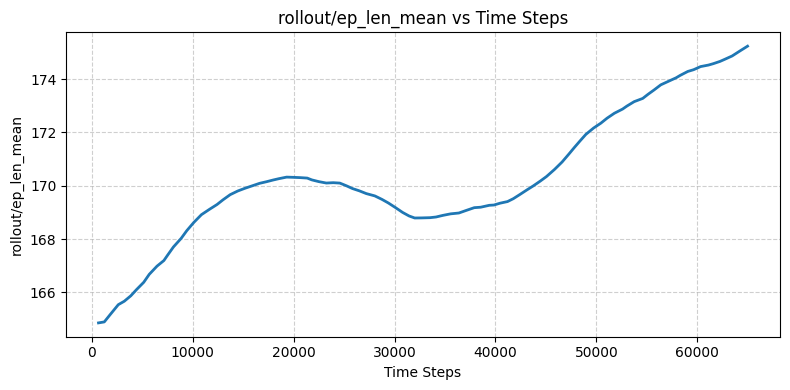

 Saved: rollout_ep_rew_mean.png


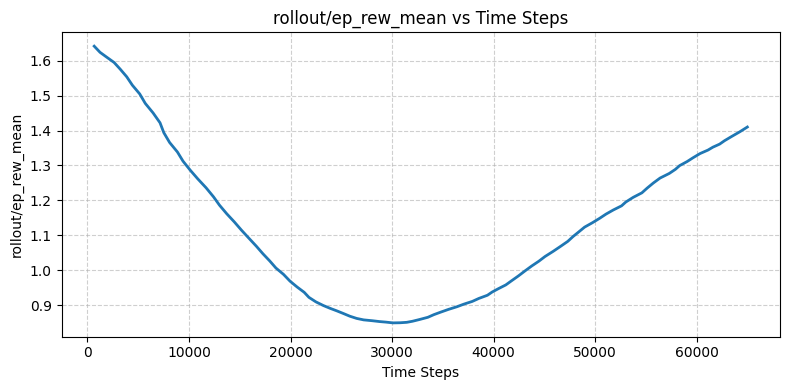

 Saved: rollout_exploration_rate.png


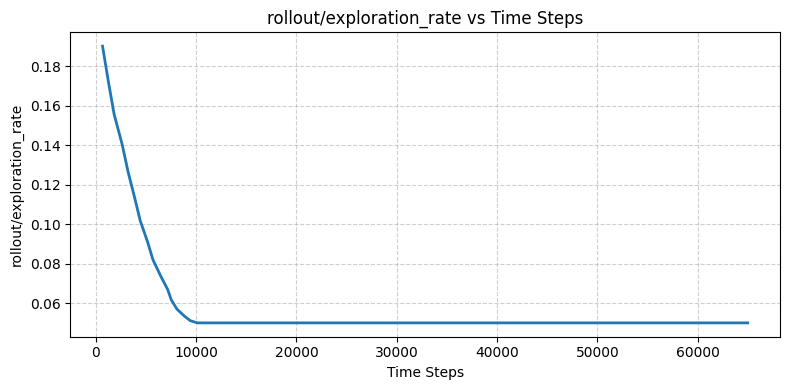

 Saved: time_fps.png


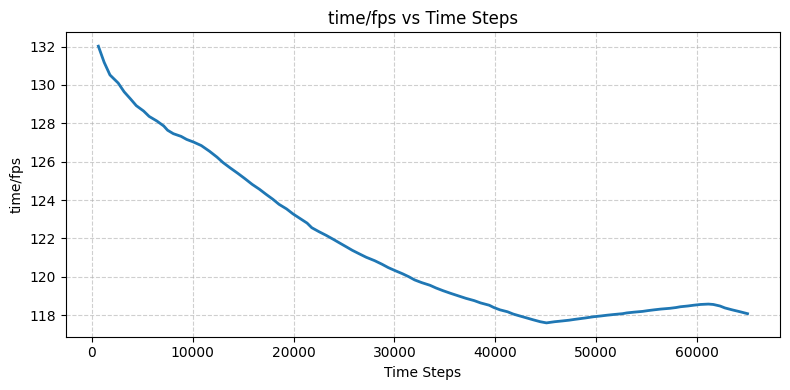

 Saved: train_learning_rate.png


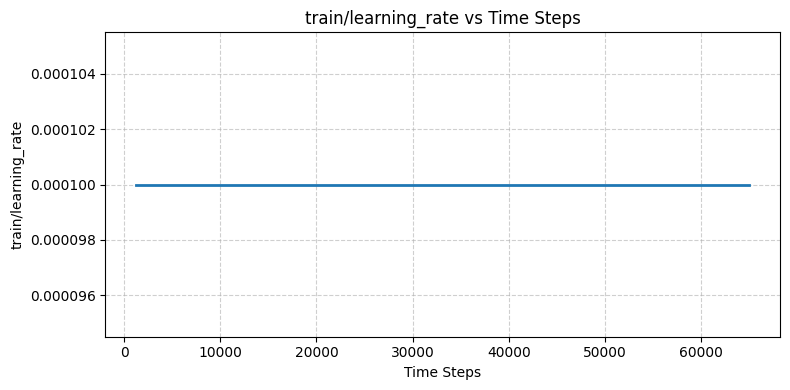

 Saved: train_loss.png


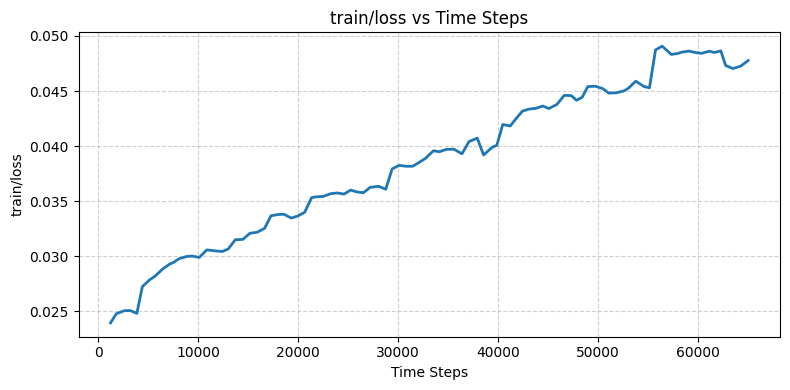

✅All available scalar metrics plotted successfully.


In [20]:
plot_tensorboard_run(
    run_dir="./logdir/crafter_reward-dqn/frame_stacked\DQN_Crafter_FrameStacked_1",
    save_dir="./logdir/crafter_reward-dqn/plots"
)

In [27]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

log_file = "D:\\BDA Honours\\Reinforcement Learning\\assignment\\Reinforcement-Learning-Project-2026-Crafter-main\\logdir\\crafter_reward-dqn\\frame_stacked\\DQN_Crafter_FrameStacked_1"

event_acc = EventAccumulator(log_file)
event_acc.Reload()

print("Available metrics:", event_acc.Tags()["scalars"])

metrics = {
    "reward": "rollout/ep_rew_mean",
    "episode_length": "rollout/ep_len_mean",
    "exploration_rate": "rollout/exploration_rate",
    "train_loss": "train/loss",
    "learning_rate": "train/learning_rate",
    "fps": "time/fps"
}

for name, tag in metrics.items():
    if tag in event_acc.Tags()["scalars"]:
        data = event_acc.Scalars(tag)
        df = pd.DataFrame([(d.step, d.value) for d in data], columns=["step", name])
        df.to_csv(f"{name}_frame_stacked.csv", index=False)
        print(f"Saved: {name}_frame_stacked.csv")
    else:
        print(f"Metric '{tag}' not found.")


Available metrics: ['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'rollout/exploration_rate', 'time/fps', 'train/learning_rate', 'train/loss']
Saved: reward_frame_stacked.csv
Saved: episode_length_frame_stacked.csv
Saved: exploration_rate_frame_stacked.csv
Saved: train_loss_frame_stacked.csv
Saved: learning_rate_frame_stacked.csv
Saved: fps_frame_stacked.csv


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import crafter
from shimmy import GymV21CompatibilityV0
import os

class Args:
    outdir = 'logdir/crafter_reward-ppo/0'
    steps = 1e5 
    save_video = False  

args = Args()

os.makedirs(args.outdir, exist_ok=True)

def make_env():
    env = crafter.Env()  # raw environment
    env = crafter.Recorder(
        env,
        args.outdir,
        save_stats=True,
        save_video=args.save_video,  
        save_episode=False,
    )
    env = GymV21CompatibilityV0(env=env)
    return env

# Wrap in vectorized + frame-stacked environment for PPO
env = DummyVecEnv([make_env])
env = VecFrameStack(env, n_stack=4)

model = PPO(
    "CnnPolicy",
    env,
    verbose=1,
    tensorboard_log=args.outdir,
    learning_rate=1e-4,
    n_steps=512,
    batch_size=64,
    n_epochs=5,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01
)

print(f"Training for {int(args.steps)} steps...")
model.learn(total_timesteps=int(args.steps), tb_log_name="ppo_crafter")
model.save(f"{args.outdir}/crafter_ppo_model")

print("Training completed!")
print(f"Logs saved to: {args.outdir}")


Using cuda device
Wrapping the env in a VecTransposeImage.
Training for 100000 steps...
Logging to logdir/crafter_reward-ppo/0\ppo_crafter_4
----------------------------
| time/              |     |
|    fps             | 91  |
|    iterations      | 1   |
|    time_elapsed    | 5   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.009743886  |
|    clip_fraction        | 0.0465       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0029770136 |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0439      |
|    n_updates            | 5            |
|    policy

KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import argparse
import crafter
from shimmy import GymV21CompatibilityV0
import os

parser = argparse.ArgumentParser()
parser.add_argument('--outdir', default='logdir/crafter_reward-ppo/0')
parser.add_argument('--steps', type=float, default=100000)

args, unknown = parser.parse_known_args()

os.makedirs(args.outdir, exist_ok=True)

def make_env():
    env = crafter.Env()
    env = crafter.Recorder(
        env,
        args.outdir,
        save_stats=True,
        save_video=False,   #  Disable video recording
        save_episode=False, #  Disable saving individual episodes
    )
    env = GymV21CompatibilityV0(env=env)
    return env

vec_env = DummyVecEnv([make_env])
vec_env = VecFrameStack(vec_env, n_stack=4)

model = PPO(
    "CnnPolicy",
    vec_env,
    verbose=1,
    tensorboard_log=args.outdir,
    learning_rate=1e-4,
    n_steps=512,
    batch_size=64,
    n_epochs=5,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01
)

print(f"Training for {args.steps} steps...")
print(f"Logs will be saved to: {args.outdir}")

model.learn(total_timesteps=int(args.steps), tb_log_name="ppo_crafter")
model.save(f"{args.outdir}/crafter_ppo_model")

print("Training completed!")
print(f"Logs and model saved to: {args.outdir}")


Using cuda device
Wrapping the env in a VecTransposeImage.
Training for 100000 steps...
Logs will be saved to: logdir/crafter_reward-ppo/0
Logging to logdir/crafter_reward-ppo/0\ppo_crafter_2
----------------------------
| time/              |     |
|    fps             | 93  |
|    iterations      | 1   |
|    time_elapsed    | 5   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.00568692   |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.048831105 |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00985     |
|  

Loading TensorBoard data from: ./logdir/crafter_reward-ppo/0/ppo_crafter_2
Found 10 scalar metrics
 Saved: time_fps.png


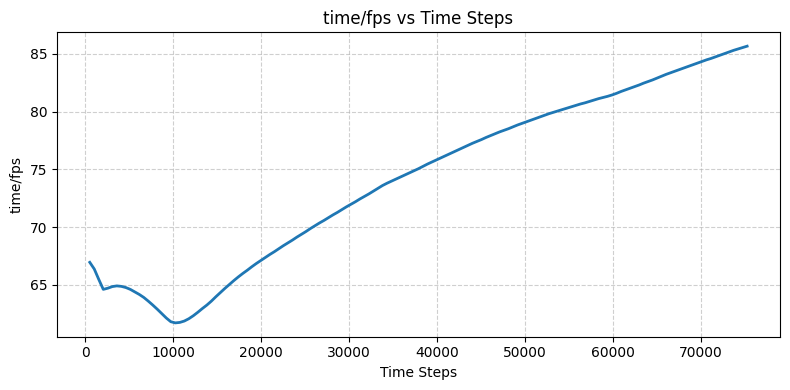

 Saved: train_approx_kl.png


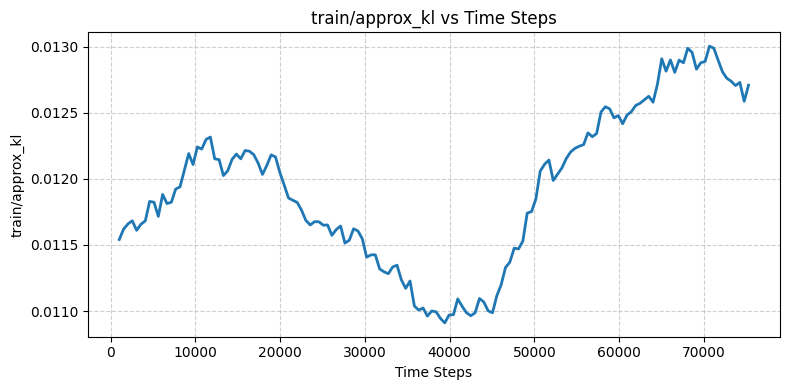

 Saved: train_clip_fraction.png


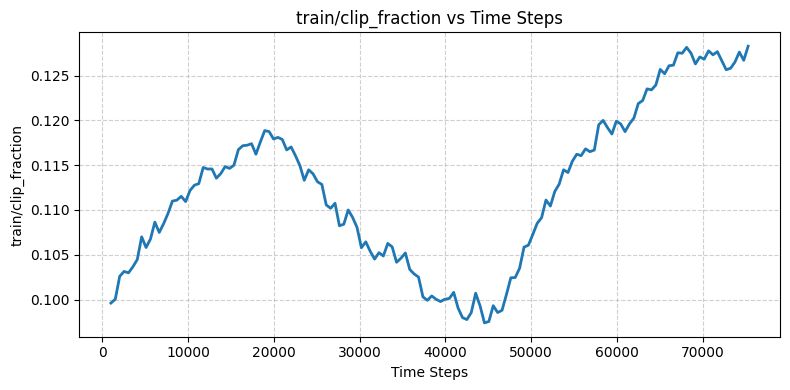

 Saved: train_clip_range.png


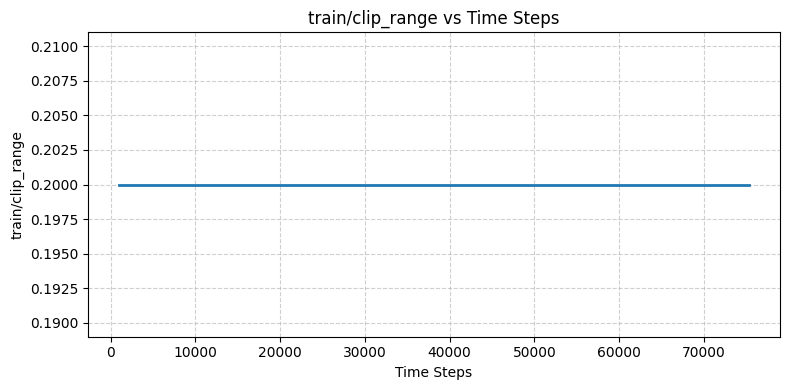

 Saved: train_entropy_loss.png


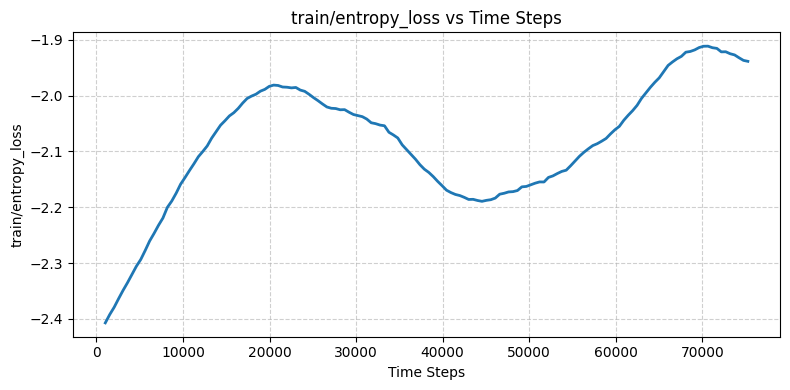

 Saved: train_explained_variance.png


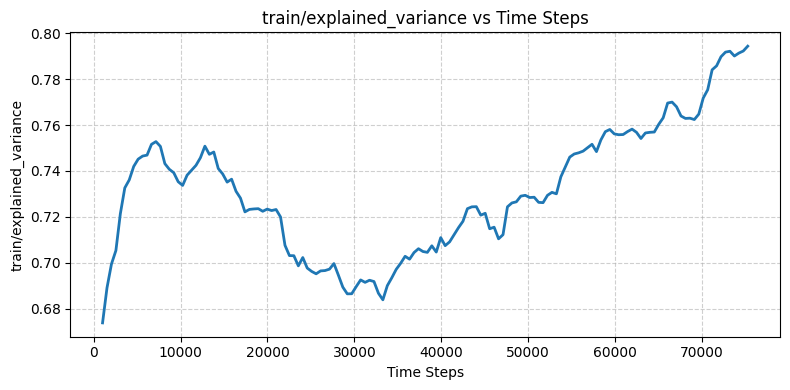

 Saved: train_learning_rate.png


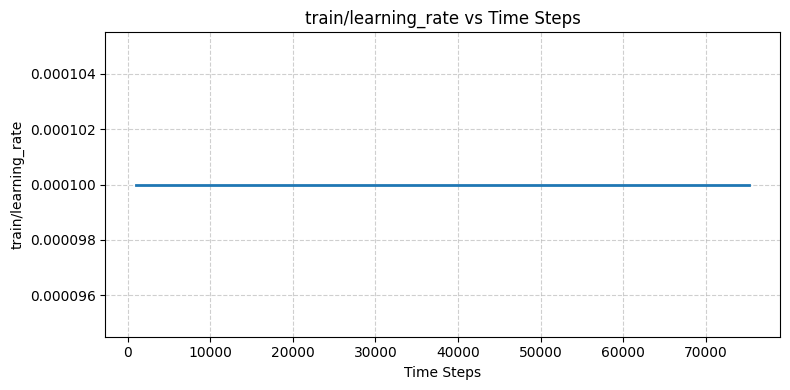

 Saved: train_loss.png


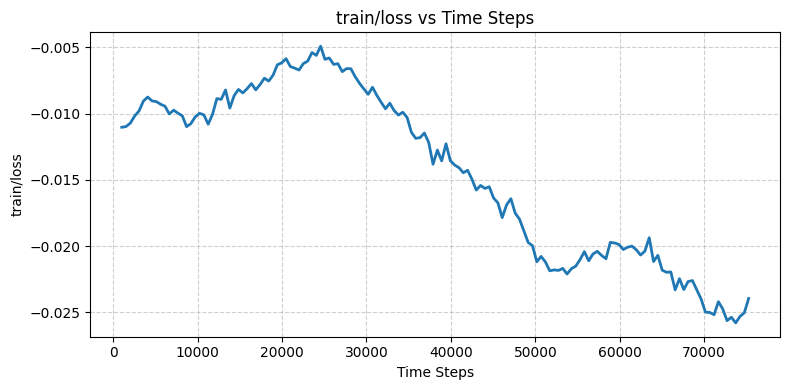

 Saved: train_policy_gradient_loss.png


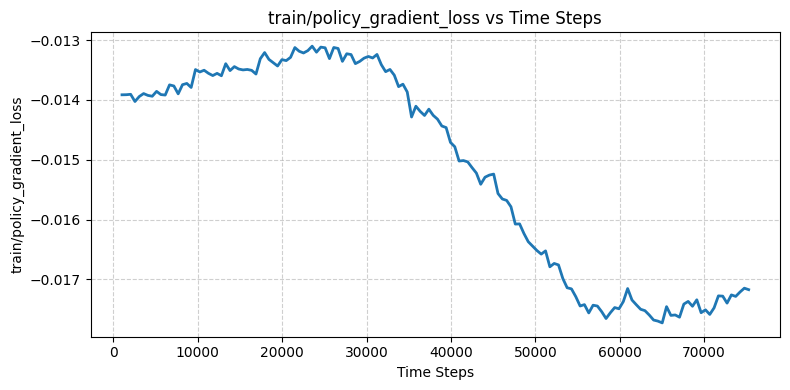

 Saved: train_value_loss.png


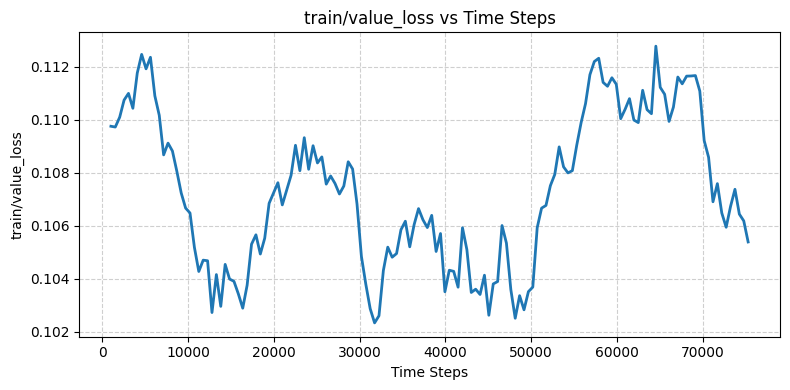

All available scalar metrics plotted successfully.


In [7]:
plot_tensorboard_run(
    run_dir="./logdir/crafter_reward-ppo/0/ppo_crafter_2",
    save_dir="./logdir/crafter_reward-ppo/plots"
)